K = 1 | Acurácia: 0.8767
K = 3 | Acurácia: 0.8794
K = 5 | Acurácia: 0.8772
K = 7 | Acurácia: 0.8794
K = 9 | Acurácia: 0.8825
K = 11 | Acurácia: 0.8854
K = 13 | Acurácia: 0.8873
K = 15 | Acurácia: 0.8844
K = 17 | Acurácia: 0.8854
K = 19 | Acurácia: 0.8844
K = 21 | Acurácia: 0.8841


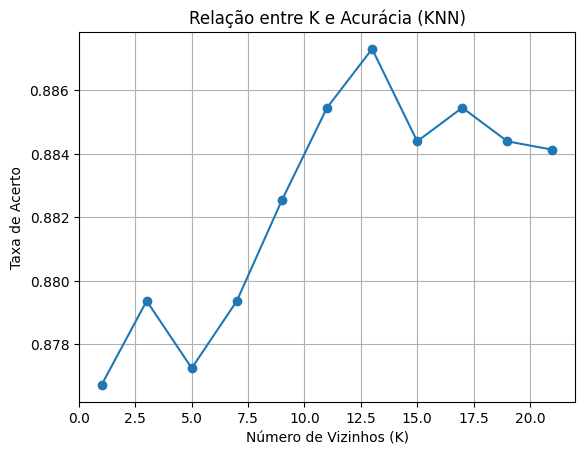

Acurácia média (validação cruzada) com K=13: 0.8140
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1931
           1       0.85      0.93      0.89      1849

    accuracy                           0.89      3780
   macro avg       0.89      0.89      0.89      3780
weighted avg       0.89      0.89      0.89      3780



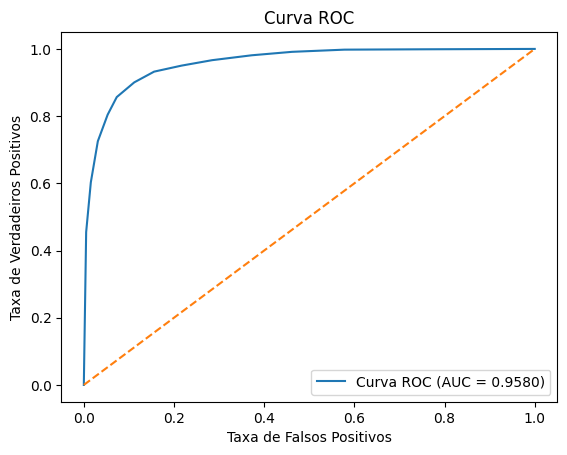

Sensibilidade: 0.9324
Especificidade: 0.8441


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Leitura dos arquivos CSV com notícias falsas e verdadeiras
falsas = pd.read_csv("Fake.csv", header=None)
verdadeiras = pd.read_csv("True.csv", header=None)

# Adiciona a coluna de classificação: 0 = falsa, 1 = verdadeira
falsas["classe"] = 0
verdadeiras["classe"] = 1

# Combina título e conteúdo da notícia em uma única coluna
falsas["conteudo"] = falsas[0] + " " + falsas[1]
verdadeiras["conteudo"] = verdadeiras[0] + " " + verdadeiras[1]

# Mescla os dois conjuntos em um único DataFrame
dados = pd.concat([falsas, verdadeiras])

# Geração da matriz de características com TF-IDF
tfidf = TfidfVectorizer(stop_words="english", max_df=0.8, min_df=5, ngram_range=(1, 2))
X = tfidf.fit_transform(dados["conteudo"])
y = dados["classe"]

# Separa os dados em subconjuntos de treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Avaliação de diferentes valores de K
valores_k = list(range(1, 22, 2))
resultados = []

for k in valores_k:
    modelo = KNeighborsClassifier(n_neighbors=k)
    modelo.fit(X_treino, y_treino)
    previsoes = modelo.predict(X_teste)
    taxa_acerto = accuracy_score(y_teste, previsoes)
    resultados.append(taxa_acerto)
    print(f"K = {k} | Acurácia: {taxa_acerto:.4f}")

# Geração de gráfico: Acurácia vs K
plt.figure()
plt.plot(valores_k, resultados, marker='o')
plt.xlabel("Número de Vizinhos (K)")
plt.ylabel("Taxa de Acerto")
plt.title("Relação entre K e Acurácia (KNN)")
plt.grid(True)
plt.show()

# Melhor valor de K com validação cruzada
melhor_k = valores_k[resultados.index(max(resultados))]
modelo_otimizado = KNeighborsClassifier(n_neighbors=melhor_k)
validacao = cross_val_score(modelo_otimizado, X, y, cv=5, scoring="accuracy")
print(f"Acurácia média (validação cruzada) com K={melhor_k}: {validacao.mean():.4f}")

# Treinamento e avaliação final do modelo KNN
modelo_otimizado.fit(X_treino, y_treino)
resultado_final = modelo_otimizado.predict(X_teste)
print("Relatório de Classificação:")
print(classification_report(y_teste, resultado_final))

# Curva ROC e AUC
probs = modelo_otimizado.predict_proba(X_teste)[:, 1]
fpr, tpr, limites = roc_curve(y_teste, probs)
valor_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {valor_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Matriz de confusão, sensibilidade e especificidade
matriz = confusion_matrix(y_teste, resultado_final)
verd_neg, fals_pos, fals_neg, verd_pos = matriz.ravel()
sens = verd_pos / (verd_pos + fals_neg)
esp = verd_neg / (verd_neg + fals_pos)
print(f"Sensibilidade: {sens:.4f}")
print(f"Especificidade: {esp:.4f}")
